# Calculating the Dimension Reduction Ensemble Similarity between ensembles

Here we compare the conformational ensembles of proteins in four trajectories, using the dimension reduction ensemble similarity method.

**Last executed:** May 18, 2021 with MDAnalysis 1.1.1

**Last updated:** September 2020

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [scikit-learn](https://scikit-learn.org/stable/)
   
**Optional packages for visualisation:**

* [matplotlib](https://matplotlib.org)


<div class="alert alert-info">
    
**Note**

The metrics and methods in the `encore` module are from (<a data-cite="tiberti_encore_2015" href="https://doi.org/10.1371/journal.pcbi.1004415">Tiberti *et al.*, 2015</a>). Please cite them when using the ``MDAnalysis.analysis.encore`` module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import (PSF, DCD, DCD2, GRO, XTC, 
                                        PSF_NAMD_GBIS, DCD_NAMD_GBIS)
from MDAnalysis.analysis import encore
from MDAnalysis.analysis.encore.dimensionality_reduction import DimensionalityReductionMethod as drm

import numpy as np
import matplotlib.pyplot as plt
# This import registers a 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)

In [2]:
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)

labels = ['DCD', 'DCD2', 'NAMD']

The trajectories can have different lengths, as seen below.

In [3]:
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 100


## Calculating dimension reduction similarity with default settings

The dimension reduction similarity method projects ensembles onto a lower-dimensional space using your chosen dimension reduction algorithm (by default: stochastic proximity embedding). A probability density function is estimated with [Gaussian-based kernel-density estimation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html), using Scott's rule to select the bandwidth.

The similarity of each probability density function is compared using the Jensen-Shannon divergence. This divergence has an upper bound of $\ln{(2)}$ and a lower bound of 0.0. Normally, $\ln{(2)}$ represents no similarity between the ensembles, and 0.0 represents identical conformational ensembles. However, due to the stochastic nature of the dimension reduction, two identical symbols will not necessarily result in an exact divergence of 0.0. In addition, calculating the similarity with `dres()` twice will result in similar but not identical numbers.

You do not need to align your trajectories, as the function will align it for you (along your `select`ion atoms, which are `select='name CA'` by default). The function we use is `dres` ([API docs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/encore/similarity.html#MDAnalysis.analysis.encore.similarity.dres)).

In [4]:
dres0, details0 = encore.dres([u1, u2, u3])

`encore.dres` returns two outputs. `dres0` is the similarity matrix for the ensemble of trajectories.

In [5]:
dres0

array([[0.        , 0.68814591, 0.67615372],
       [0.68814591, 0.        , 0.66800132],
       [0.67615372, 0.66800132, 0.        ]])

`details0` contains information on the dimensionality reduction, as well as the associated reduced coordinates. Each frame is in the conformational ensemble is reduced to 3 dimensions.

In [6]:
reduced = details0['reduced_coordinates'][0]
reduced.shape

(3, 300)

### Plotting

As with the other ensemble similarity methods, we can plot a flat matrix of similarity values.

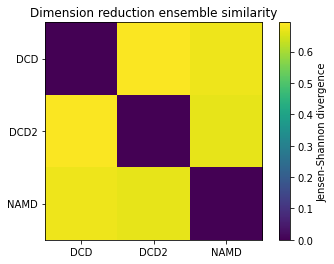

In [7]:
fig0, ax0 = plt.subplots()
im0 = plt.imshow(dres0, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Dimension reduction ensemble similarity')
cbar0 = fig0.colorbar(im0)
cbar0.set_label('Jensen-Shannon divergence')

We can also plot the reduced coordinates to directly visualise where each trajectory lies in the lower-dimensional space.

For the plotting of the reduced dimensions, we define a helper function to make it easier to partition the data.

In [8]:
def zip_data_with_labels(reduced):
    rd_dcd = reduced[:, :98]  # first 98 frames
    rd_dcd2 = reduced[:, 98:(98+102)]  # next 102 frames
    rd_namd = reduced[:,(98+102):]  # last 100 frames
    return zip([rd_dcd, rd_dcd2, rd_namd], labels)

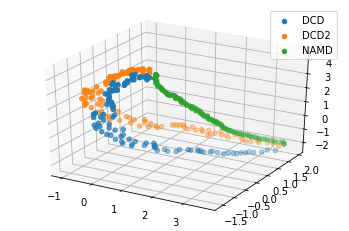

In [9]:
rdfig0 = plt.figure()
rdax0 = rdfig0.add_subplot(111, projection='3d')
for data, label in zip_data_with_labels(reduced):
    rdax0.scatter(*data, label=label)
plt.legend()

## Calculating dimension reduction similarity with one method

Dimension reduction methods should be subclasses of `analysis.encore.dimensionality_reduction.DimensionalityReductionMethod`, initialised with your chosen parameters. 

Below, we set up stochastic proximity embedding scheme, which maps data to lower dimensions by iteratively adjusting the distance between a pair of points on the lower-dimensional map to match their full-dimensional proximity. The learning rate controls the magnitude of these adjustments, and decreases over the mapping from `max_lam` (default: 2.0) to `min_lam` (default: 0.1) to avoid numerical oscillation. The learning rate is updated every cycle for `ncycle`s, over which `nstep` adjustments are performed.

The number of dimensions to map to is controlled by the keyword `dimension` (default: 2).

In [10]:
dim_red_method = drm.StochasticProximityEmbeddingNative(dimension=3,
                                                        min_lam=0.2,
                                                        max_lam=1.0,
                                                        ncycle=50,
                                                        nstep=1000)

You can also control the number of samples `nsamples` drawn from the ensembles used to calculate the Jensen-Shannon divergence.

By default, MDAnalysis will run the job on one core. If it is taking too long and you have the resources, you can increase the number of cores used.

In [11]:
dres1, details1 = encore.dres([u1, u2, u3],
                         select='name CA',
                         dimensionality_reduction_method=dim_red_method,
                         nsamples=1000,
                         ncores=4)

### Plotting

Reducing the learning rate, number of cycles, and number of steps for the stochastic proximity embedding seems to have left our trajectories closer on the lower-dimensional map.

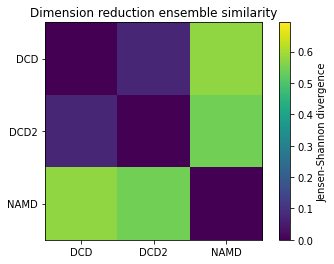

In [12]:
fig1, ax1 = plt.subplots()
im1 = plt.imshow(dres1, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Dimension reduction ensemble similarity')
cbar1 = fig1.colorbar(im1)
cbar1.set_label('Jensen-Shannon divergence')

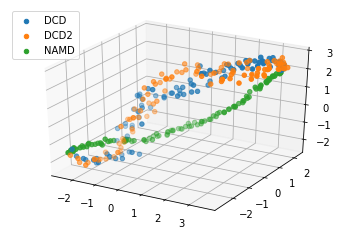

In [13]:
reduced1 = details1['reduced_coordinates'][0]

rdfig1 = plt.figure()
rdax1 = rdfig1.add_subplot(111, projection='3d')
for data, label in zip_data_with_labels(reduced1):
    rdax1.scatter(*data, label=label)
plt.legend()

## Calculating dimension reduction similarity with multiple methods

You may want to try different dimension reduction methods, or use different parameters within the methods. `encore.dres` allows you to pass a list of `dimensionality_reduction_method`s to be applied.

<div class="alert alert-info">
    
**Note**

To use the other ENCORE methods available, you need to install [scikit-learn](https://scikit-learn.org/stable/).

</div>

### Trying out different dimension reduction parameters

Principal component analysis uses singular value decomposition to project data onto a lower dimensional space. [(See the scikit-learn user guide for more information.)](https://scikit-learn.org/stable/modules/decomposition.html#pca)

The method provided by MDAnalysis.encore accepts any of the keyword arguments of [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) *except* `n_components`. Instead, use `dimension` to specify how many components to keep.

In [14]:
pc1 = drm.PrincipalComponentAnalysis(dimension=1,
                                     svd_solver='auto')
pc2 = drm.PrincipalComponentAnalysis(dimension=2,
                                     svd_solver='auto')
pc3 = drm.PrincipalComponentAnalysis(dimension=3,
                                     svd_solver='auto')
pc4 = drm.PrincipalComponentAnalysis(dimension=4,
                                     svd_solver='auto')

When we pass a list of clustering methods to `encore.dres`, the results get saved in `dres2` and `details2` in order.

In [15]:
dres2, details2 = encore.dres([u1, u2, u3],
                         select='name CA',
                         dimensionality_reduction_method=[pc1, pc2, pc3, pc4],
                         ncores=4)
print(len(dres2), len(details2['reduced_coordinates']))

4 4


### Plotting

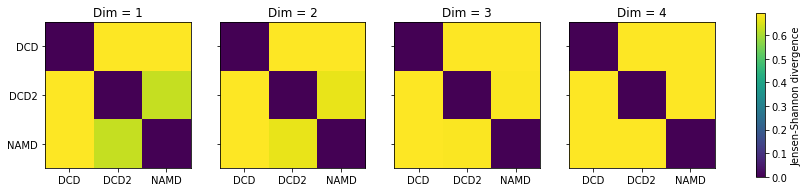

In [16]:
titles = ['Dim = {}'.format(n) for n in range(1, 5)]
fig2, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i, (data, title) in enumerate(zip(dres2, titles)):
    imi = axes[i].imshow(data, vmax=np.log(2), vmin=0)
    axes[i].set_xticks(np.arange(3))
    axes[i].set_xticklabels(labels)
    axes[i].set_title(title)
plt.yticks(np.arange(3), labels)
cbar2 = fig2.colorbar(imi, ax=axes.ravel().tolist())
cbar2.set_label('Jensen-Shannon divergence')

In this case, adding more dimensions to the principal component analysis has little difference in how similar each ensemble is over its resulting probability distribution (i.e. not similar at all!)

In [17]:
rd_p1, rd_p2, rd_p3, _ = details2['reduced_coordinates']

If we plot how the trajectories vary on one dimension with a violin plot, we can see that DCD is indeed very distant from DCD2 and NAMD on the first principal component.

[Text(0, 0, 'DCD'), Text(0, 0, 'DCD2'), Text(0, 0, 'NAMD')]

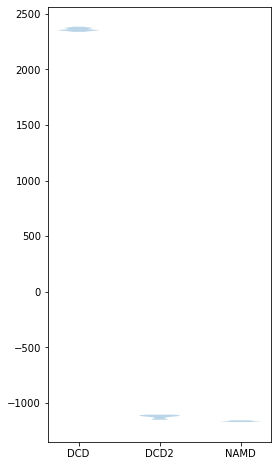

In [18]:
rd_p1_fig, rd_p1_ax = plt.subplots(figsize=(4, 8))
split_data = [x[0].reshape((-1,)) for x in zip_data_with_labels(rd_p1)]
rd_p1_ax.violinplot(split_data, showextrema=False)
rd_p1_ax.set_xticks(np.arange(1, 4))
rd_p1_ax.set_xticklabels(labels)

Expanding out to the second principal component shows that DCD2 and NAMD mainly vary on the second axis.

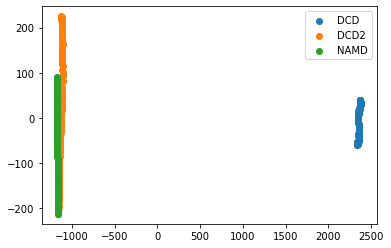

In [19]:
rd_p2_fig, rd_p2_ax = plt.subplots()
for data, label in zip_data_with_labels(rd_p2):
    rd_p2_ax.scatter(*data, label=label)
plt.legend()

Plotting over the top three principal components gives quite a different result to the reduced coordinates given by stochastic proximity embedding.

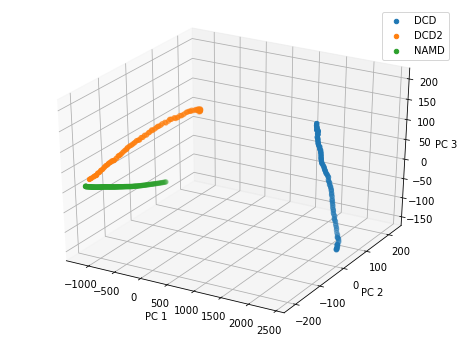

In [20]:
rd_p3_fig = plt.figure(figsize=(8, 6))
rd_p3_ax = rd_p3_fig.add_subplot(111, projection='3d')
for data, label in zip_data_with_labels(rd_p3):
    rd_p3_ax.scatter(*data, label=label)
rd_p3_ax.set_xlabel('PC 1')
rd_p3_ax.set_ylabel('PC 2')
rd_p3_ax.set_zlabel('PC 3')
plt.legend()

## Estimating the error in a dimension reduction ensemble similarity analysis

`encore.dres` also allows for error estimation using a bootstrapping method. This returns the average Jensen-Shannon divergence, and standard deviation over the samples. 

In [21]:
avgs, stds = encore.dres([u1, u2, u3],
                         select='name CA',
                         dimensionality_reduction_method=dim_red_method,
                         estimate_error=True,
                         ncores=4)

In [22]:
avgs

array([[0.        , 0.25148565, 0.59436574],
       [0.25148565, 0.        , 0.59185462],
       [0.59436574, 0.59185462, 0.        ]])

In [23]:
stds

array([[0.        , 0.07238521, 0.05236259],
       [0.07238521, 0.        , 0.05092071],
       [0.05236259, 0.05092071, 0.        ]])

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Matteo Tiberti, Elena Papaleo, Tone Bengtsen, Wouter Boomsma, and Kresten Lindorff-Larsen.
<span class="bibtex-protected">ENCORE</span>: <span class="bibtex-protected">Software</span> for <span class="bibtex-protected">Quantitative</span> <span class="bibtex-protected">Ensemble</span> <span class="bibtex-protected">Comparison</span>.
<em>PLOS Computational Biology</em>, 11(10):e1004415, October 2015.
00031.
URL: <a href="https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004415">https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004415</a>, <a href="https://doi.org/10.1371/journal.pcbi.1004415">doi:10.1371/journal.pcbi.1004415</a>.